# Кластеризация

<img src ="https://edunet.kea.su/repo/EduNet-content/L01/out/clustering_task.png" width="600" >



Кластеризация — **разбиение множества входных сигналов на классы при том, что ни количество, ни признаки классов заранее не известны**. После обучения модель способна определять, к какому классу относится входной сигнал. Модель также может сигнализировать о том, что входной сигнал не относится ни к одному из выделенных классов — это является признаком новых, отсутствующих в обучающей выборке данных. Таким образом, подобная модель может выявлять новые, неизвестные ранее классы сигналов. Соответствие между классами, выделенными сетью, и классами, существующими в предметной области, устанавливается человеком.

Относится к задачам **обучения без учителя**.

# Методы понижения размерности

Примените методы понижения размерности: PCA, t-SNE и UMAP к изображениям клеток крови из датасета BloodMNIST. Отобразите проекцию данных на двумерное пространство, так как это допускает наиболее простую визуализацию полученного результата (воспользуйтесь [`sns.scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)).  Какой метод позволяет лучше разделить данные в пространстве? Опишите ваши наблюдения. 

Произведем загрузку данных:

In [16]:
!pip install -q gdown
!pip install -q umap-learn
!pip install -q --upgrade git+https://github.com/MedMNIST/MedMNIST.git
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/dataset_without_pytorch.py

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [22]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn
import umap
import medmnist
import time
import warnings

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn import manifold
from medmnist import INFO, Evaluator

matplotlib.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings("ignore")

## PCA (Метод главных компонент)

Метод главных компонент (Principal Component Analysys, PCA) — простейший линейный метод снижения размерности, описан [Пирсоном в 1901 году](http://pca.narod.ru/pearson1901.pdf).



Идея заключается в преобразовании $D$ исходных признаков таким образом, чтобы получить $d$ признаков, содержащих как можно больше информации из исходных признаков:

$$\large z_{ij} = \sum^D_{k=1}w_{jk}x_{ik},$$

где: $\; z_{ij}$ — новые признаки ($d$ штук),

$\qquad x_{ik}$ — исходные признаки ($D$ штук),

$\qquad w_{jk}$ — вклад исходного $k$-го признака в новый $j$-й.

Запишем линейное преобразование исходного признакового пространства в **матричном виде**.

Требование — ортогональность матрицы $W: W^TW = I$, где $I$ — единичная матрица.

Получение новых признаков $Z$ осуществляется домножением исходных признаков $X$ на матрицу $W: XW=Z$.

Следовательно, $X=ZW^T$

Задача: $\displaystyle ||X-ZW^T||^2 \rightarrow \min_{W}$

$$$$

#### Максимизация дисперсии выборки после понижения размерности

Рассмотрим простой пример для понимания интуиции, которая стоит за методом главных компонент.

У нас есть выборка объектов с двумя признаками $x_1$ и $x_2$, отобразим их на плоскости. Мы хотим, чтобы у нас был только один признак, который характеризует наши данные. Тогда наша задача — провести прямую через наши точки так, чтобы она наилучшим образом характеризовала наши данные

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/pca_dataset_example.png" width="400"/>

Проведем прямую вдоль максимального изменения данных и спроецируем точки на нее. Это и будет наша первая главная компонента.

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/first_component_example.png" width="400"/>

Теперь мы можем использовать только один признак, который лежит на новой оси, а любые отклонения от нее это просто шум (в действительности, определить, что является шумом в данных это нетривиальная задача).

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/proection_component.png" width="400"/>

Это то, как можно понимать интуицию работы PCA.

В более многомерном случае (например, при количестве признаков 200) мы бы делали то же самое:

1. Выбираем направление максимального изменения данных — это первая главная компонента.
2. Если данные описаны не полностью, то выбираем еще одно направление — перпендикулярное к первому, так, чтобы описать оставшееся изменение в данных.
3. Повторяем пункт 2, пока компонент не будет достаточно, вплоть до размерности исходного пространства. При этом каждая следующая компонента будет перпендикулярна предыдущим и объяснять меньше дисперсии, чем любая из них.

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/3d_to_2d_pca.png" width="1000"/>

### Пример с Титаником

Чтобы понять, как использовать PCA на практике, найдем главные компоненты для датасета Titanic и посмотрим, как распределится между ними дисперсия.

In [ ]:
import pandas as pd
import numpy as np


# The categorical-to-numerical function
# Changed to automatically add column names
def cat_to_num(data):  # one-hot encoding
    categories = set(data)
    features = {}
    for cat in categories:
        binary = data == cat
        if len(set(binary)) == 1:
            # Ignore features where all values equal
            continue
        new_key = f"{data.name}={cat}"

        features[new_key] = binary.astype("int")
    return pd.DataFrame(features)


def cabin_features(data):
    features = []
    for cabin in data:
        cabins = str(cabin).split(" ")
        n_cabins = len(cabins)
        # First char is the cabin_char
        try:
            cabin_char = cabins[0][0]
        except IndexError:
            cabin_char = "X"
            n_cabins = 0
        # The rest is the cabin number
        try:
            cabin_num = int(cabins[0][1:])
        except:
            cabin_num = -1
        # Add 3 features for each passanger
        features.append([cabin_char, cabin_num, n_cabins])
    features = np.array(features)
    dic_of_features = {
        "Cabin_num": features[:, 1].astype("int"),
        "N_cabins": features[:, 2].astype("int"),
    }
    out = pd.DataFrame(dic_of_features)
    char_column = pd.DataFrame({"Cabin_char": features[:, 0]})
    cabin_ch = cat_to_num(char_column["Cabin_char"])
    return out.join(cabin_ch)


def prepare_data(data):
    """Takes a dataframe of raw data and returns ML model features"""

    # Initially, we build a model only on the available numerical values
    features = data.drop(
        [
            "PassengerId",
            "Survived",
            "Fare",
            "Name",
            "Sex",
            "Ticket",
            "Cabin",
            "Embarked",
        ],
        axis=1,
    )

    # Setting missing age values to -1
    features["Age"] = data["Age"].fillna(-1)

    # Adding the sqrt of the fare feature
    features["sqrt_Fare"] = np.sqrt(data["Fare"])

    # Adding gender categorical value
    features = features.join(cat_to_num(data["Sex"]))

    # Adding Embarked categorical value
    features = features.join(cat_to_num(data["Embarked"]))

    # Split cabin
    features = features.join(cabin_features(data["Cabin"]))

    return features

##### Без стандартизации

Загрузим датасет и подготовим данные

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Importing the data from the .csv
# 2. Pre-processing the data and creating a feature set
# 3. Splitting the data into training and test data and labels

dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/titanic.csv"
)
features = prepare_data(dataset)
x_train, x_test, y_train, y_test = train_test_split(
    features, dataset["Survived"], test_size=0.2, random_state=42
)

Полезной информацией является коэффициент объясненной дисперсии (explained variance ratio) главной компоненты. Этот коэффициент является отношением между дисперсией главной компоненты и суммой дисперсий всех главных компонент. Он указывает долю выборочной дисперсии, которая лежит вдоль оси каждой главной компоненты.

В модуле PCA, после `fit` можно получить explained variance ratio посредством обращения к полю `explained_variance_ratio_`, а explained variance — посредством обращения к полю `explained_variance_`.



Построим график с `explained_variance_ratio_` всех компонент

In [ ]:
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# performing PCA with default number of principal components.
titanic_pca = sklearn.decomposition.PCA()
titanic_pca.fit(x_train)  # fitting our PCA model with the training data.
# calculating the explained variance of each of the components.
evr = titanic_pca.explained_variance_ratio_

# We are plotting the explained variance ratios.
plt.bar(range(evr.shape[0]), evr)
plt.title("Variance by components")
plt.xlabel("Components")
plt.ylabel("Variance")
plt.show()

In [ ]:
titanic_pca.explained_variance_.shape

Из графика не совсем понятно, сколько компонент брать, резко доля объясняемой дисперсии меняется в районе 2-компоненты. Посмотрим, сколько компонент нужно модели

In [ ]:
from sklearn.linear_model import LogisticRegression

# 1.The first thing we do is to fit a PCA model to the training set
#   of the Titanic dataset with n components from 1 to 10.
# 2.We then fit a logistic regression model to the transformed training data
#   and make predictions on the transformed test set.

for i in range(1, 11):
    titanic_pca = sklearn.decomposition.PCA(n_components=i)
    titanic_pca.fit(x_train)

    x_train_reduced = titanic_pca.transform(x_train)
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train_reduced, y_train)

    x_test_reduced = titanic_pca.transform(x_test)

    # prints the number of PCA components and the score
    # for the corresponding model.
    print("%i first components %.2f" % (i, model.score(x_test_reduced, y_test)))

Явно видим, что уже первых 7 компонент достаточно для достижения качества, которое далее не меняется. Почему же мы видим снижение уже после 2 компоненты?


Мы забыли сделать **стандартизацию** наших данных.

В нашем датасете переменные имеют совершенно разные масштабы. Из-за этого часть из них "перетегягивает" на себя всю дисперсию.

В результате по доле дисперсии судить о важности компонент нельзя.

##### Со стандартизацией

Сделаем предварительно стандартизацию

In [ ]:
# First, we import the StandardScaler module.
from sklearn.preprocessing import StandardScaler

# Next, we create a StandardScaler object called scaler by calling the
# StandardScaler() function.
scaler = StandardScaler()

#  We then fit the scaling model to our training data.
x_train = scaler.fit_transform(x_train)

# We transform your test set by applying the same scaling model.
x_test = scaler.transform(x_test)

# performing PCA with default number of principal components.
titanic_pca = sklearn.decomposition.PCA()
titanic_pca.fit(x_train)  # fitting our PCA model with the training data.


В `PCA.components_` лежат вектора главных компонент, которые располагаются там построчно (n_components, n_features).

In [ ]:
titanic_pca.components_.shape

Обратите внимание, что PCA упорядочивает собственные вектора. Это значит, что собственный вектор, соответствующий главной компоненте и, соответственно, имеющей максимальную дисперсию, будет находиться в первой строке.

In [ ]:
# calculating the explained variance of each of the components.
evr = titanic_pca.explained_variance_ratio_

# We are plotting the explained variance ratios.
plt.bar(range(evr.shape[0]), evr)
plt.title("Variance by components")
plt.xlabel("Components")
plt.ylabel("Variance")
plt.show()

Теперь видим, что не только первые две компоненты дают вклад. Это происходит потому, что переменные с большим диапазоном значений не забивают остальные.

Правда, теперь и значимого спада в доле объясняемой дисперсии мы долго не видим, поэтому встает вопрос: как выбрать число компонент так, чтобы взять нужное и отсечь ненужное?

### Как выбирать оптимальное число  компонент




Скачаем датасет, на котором польза от понижения размерности видна более явно.

В данном датасете хранятся признаки (нам сейчас не важно, какие), характеризующие примерно 8000 клеток крови.



In [ ]:
# 1. Reading in the scRNAseq data.
scRNAseq = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/scRNAseq_CITEseq.txt",
    sep="\t",
)

x_scRNAseq = scRNAseq.iloc[:, 0:-1]  # features
y_scRNAseq = scRNAseq.iloc[:, -1]  # labels

# 2. taking the log of the data.
x_scRNAseq = np.log(x_scRNAseq + 1)
print(f"dataset shape: {scRNAseq.shape}")

Подбирать число компонент можно по-разному

#### По доле объясняемой дисперсии

Часто берут минимальное число компонент, которое объясняет 95% дисперсии. Подход, очевидно, порочный (а почему не 90% или 99%), зато быстрый.

In [ ]:
# 1. We're calculating the explained variance ratio for
#    each component of the PCA.
# 2. We're plotting these ratios in a chart.

pca = PCA(n_components=x_train.shape[1])
pca.fit(x_train)

ths = 0.95
total_explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6, 6))

plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained)
plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
plt.xticks(np.arange(1, x_train.shape[1]))
plt.ylabel("total sum of  proportion  of the explained variance")
plt.xlabel("Num of components", size=14)

plt.show()

Взяли 15 компонент. Почему именно столько? Почему не 16?

Непонятно. Просто, ибо поставили такой порог. Могли поставить и другой, и тогда бы взяли больше или меньше компонент.


#### По правилу локтя

Можно построить график, отражающий, сколько дисперсии объясняет каждая из компонент, и на основе графика выбрать нужное число компонент.

Идея подхода простая: переход от компонент, объясняющих что-то важное в данных, к компонентам, объясняющим шум, должен сопровождаться резким снижением доли объясняемой дисперсии.

Или можно сказать иначе: выбранные нами компоненты должны быть устойчивы к добавлению шума в данные. Если мы нашли резкий скачок в доле объясняемой дисперсии, то маловероятно, что добавление шума этот скачок нивелирует — наш способ отбора компонент устойчив к шуму.

В идеальном случае график будет выглядеть как-то так. Но на практике таких склонов может не быть, а может быть несколько.

<img src ="https://edunet.kea.su/repo/EduNet-content/L04/out/elbow_rule.png" width="600">

In [ ]:
# 1. First, we create a PCA object that you fit to the training data.
# 2. Then, we create a a scatter plot where we plot the explained
#    variance ratio as a function of the number of PCA components.
# 3. We also plot the explained variance ratio as a function of the
#    number of components, but with a smooth curve.
# 4. Finally, we show the plot.

n_comp = x_train.shape[1]

explained = pca.explained_variance_ratio_

plt.figure(figsize=(6, 6))
plt.scatter(np.arange(1, n_comp + 1), explained)
plt.plot(np.arange(1, n_comp + 1), explained)
plt.title("Dependence of  variance on the number of components", size=14)
plt.xlabel("Num of components", size=14)
plt.ylabel("proportion of the explained variance", size=14)
plt.xticks(np.arange(1, x_train.shape[1]))
plt.show()

Понять, какое число компонент стоит выбрать, из такого графика сложно. Наверно, стоит выбрать последний склон — в нашем случае мы возьмем первые 12 компонент.



Можно применить критерий локтя и к нашему изначальному графику с суммарной долей объясненной дисперсии (в таком случае ожидаем скачок). Но там скачок также трудно обнаружить.

#### Перестановочный метод

Еще одним способом выбрать число главных компонент является перестановочный метод. Он заключается в следующем:

 1) Перемешиваем значения каждого признака.

 2)  Получаем матрицу признаков, которая не содержит никакой информации об исходном многообразии.

 3) Делаем PCA.

 4) Любая explained variance — просто из-за природы данных.

 5) Делаем так 100-1000 раз.

 6) Пусть на реальных данных k-я компонента объясняет
n% дисперсии.

 7) Смотрим на распределение доли дисперсии,
объясняемой k-компонентой для случайных данных
(полученных перемешиванием).

 8) Можем сравнить и принять решение, объясняет ли k-я
компонента что-то реальное или является просто шумом.

In [ ]:
from tqdm import tqdm
from scipy.stats import norm


def shuffle_dataset(dataset):
    random_data = {}
    for col in dataset.columns:
        random_data[col] = np.random.permutation(dataset.loc[:, col].values)
    random_data = pd.DataFrame(random_data)
    return random_data


def get_variance_by_chance(dataset, n_replics, n_components):
    variance_explained_by_chance = np.zeros((n_replics, n_components))
    for i in tqdm(range(n_replics)):
        random_data = shuffle_dataset(dataset)
        random_pca = PCA(n_components=n_components)
        random_pca.fit(random_data)
        variance_explained_by_chance[i, :] = random_pca.explained_variance_ratio_
    return variance_explained_by_chance


def get_pc_variance(dataset, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    return pca.explained_variance_ratio_


def plot_mean_and_CI(
    ax,
    values,
    label,
    ci_level=0.95,
    alpha_transparency=0.5,
    color_mean=None,
    color_shading=None,
):
    mean = values.mean(axis=0)

    std = values.std(axis=0)
    n = values.shape[1]
    se = std / np.sqrt(n)

    q_alpha = (1 - ci_level) / 2
    ci_num = np.abs(norm.ppf(q_alpha, loc=0, scale=1))

    lb = mean - ci_num * se
    ub = mean + ci_num * se

    # plot the shaded range of the confidence intervals
    ax.fill_between(
        range(mean.shape[0]), ub, lb, color=color_shading, alpha=alpha_transparency
    )
    # plot the mean on top
    ax.plot(mean, c=color_mean, lw=3, label=label)


def plot_explained_variance(ax, variance):
    ax.plot(variance, label="real", lw=3)
    ax.scatter(np.arange(0, variance.shape[0]), variance)


def plot_variance_by_change(ax, variance_by_chance):
    plot_mean_and_CI(
        ax, variance_by_chance, label="chance", color_mean="red", color_shading="red"
    )


def calc_permutat_pval(real_values, permut_values, eps=None):
    eps = eps or (1 / (permut_values.shape[0] * 10))

    p_values = np.zeros_like(real_values)
    for i in range(0, p_values.shape[0], 1):
        p_values[i] = (permut_values[:, i] >= real_values[i]).mean() + eps
    return p_values


def plot_explained_vs_chance(
    ax, explained_variance, variance_by_chance, dataset_name, step=1
):
    plot_explained_variance(ax, explained_variance)
    plot_variance_by_change(ax, variance_by_chance)

    ax.set_title(f"PCA {dataset_name}", size=25)
    ax.set_xlabel("Component number", size=15)
    ax.set_ylabel("Explained variance ration", size=15)
    ax.set_xticks(np.arange(0, explained_variance.shape[0], step))
    ax.set_xticklabels(np.arange(1, explained_variance.shape[0] + 1, step), size=10)

    ax.tick_params(labelsize=10, size=8)
    ax.set_ylim(0, explained_variance[0] + 0.1)
    ax.legend(fontsize=15)


def plot_pval_plot(ax, p_values, dataset_name, alpha_level=0.05, logscale=True, step=1):
    if logscale:
        p_values = -np.log10(p_values)
        alpha_level = -np.log10(alpha_level)

    ax.set_title(f"PC significance, {dataset_name}", size=25)
    ax.plot(p_values, lw=3)
    ax.scatter(np.arange(0, p_values.shape[0]), p_values, lw=3)

    ax.set_xlabel("Component number", size=15)
    ax.set_ylabel("-log(pvalue + eps)", size=15)
    ax.set_xticks(np.arange(0, p_values.shape[0], step))

    ax.set_xticklabels(labels=np.arange(1, p_values.shape[0] + 1, step), size=10)
    ax.tick_params(labelsize=10, size=8)

    ax.hlines(
        y=alpha_level,
        xmin=0,
        xmax=p_values.shape[0],
        color="red",
        linestyles="dashed",
        lw=3,
    )


def pca_analysis(ax1, ax2, dataset, title, n_components=None, n_replics=1000, step=1):
    n_components = n_components or dataset.shape[1]
    explained_variance = get_pc_variance(dataset, n_components)
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)
    plot_explained_vs_chance(ax1, explained_variance, variance_by_chance, title)
    plot_pval_plot(ax2, p_values, title)

In [ ]:
np.random.seed(42)
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(7)
f.set_figwidth(7)
plt.subplots_adjust(top=1.7)
pca_analysis(ax1, ax2, pd.DataFrame(x_train), "Titanic", n_replics=10, n_components=10)

### Проблемы  PCA




##### Интересное направление в данных может не совпадать с направлением максимальной дисперсии.

Рассмотрим случай выборки, которая сгенерирована из двух вытянутых нормальных распределений, чьи основные оси неортогональны друг другу:

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/problem_pca_2.png" width="600"/>

##### Выбранные оси могут вообще не подходить для нашей задачи


В примере ниже дисперсии не отражают интересующих нас направлений в данных:

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/problem_pca_1.png" width="600"/>

Очевидно, что в данном случае метод главных компонент будет считать вертикальную компоненту более значимой для описания набора данных, чем горизонтальную.

Но, например, в случае, когда данные из левого и правого кластера относятся к разным классам, для их линейной разделимости вертикальная компонента является шумовой. Несмотря на это, её метод главных компонент никогда шумовой не признает, и есть вероятность, что отбор признаков с его помощью выкинет из ваших данных значимые для решаемой вами задачи компоненты просто потому, что вдоль них значения имеют низкую дисперсию.

Справляться с такими ситуациями могут некоторые другие методы уменьшения размерности данных, например, метод независимых компонент (Independent Component Analysis, ICA).

#### Недостатки линейного PCA

Как мы увидели в предыдущих примерах, обычный PCA далеко не всегда работает хорошо. В частности, могут быть ситуации, когда построенная PCA проекция не дает хорошего разбиения объектов на группы. Для набора картинок с написанными от руки цифрами  MNIST, PCA даст такой результат:

<center><img src="https://edunet.kea.su/repo/EduNet-content/L04/out/pca_tsne_umap_on_mnist.png" width="1000"/></center>

Также бывают ситуации, когда оптимально спроецировать не на некоторую плоскость, а на многообразие (кривая плоскость), как показано на картинке ниже.

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/s_manifold.png" width="650"/>

В данном случае оптимально спроецировать на S-образную кривую.

В связи с вышеописанными случаями, ниже мы рассмотрим более сильные методы.

## Kernel PCA Ядровой (нелинейный) метод главных компонент

Как уже упоминалось, иногда невозможно захватить всю информацию линейной проекцией, хотя кривая поверхность с такой же размерностью это позволяет сделать. Одним из подходов к решению данной проблемы является задача перевода признаков в нелинейное пространство.

### Kernel trick

Kernel Trick избегает явного перевода наших признаков в пространство новых признаков, ведь пространства бывают очень большие, а нам бы хотелось сэкономить память компьютера.
Оказывается, для PCA не важны собственно признаки объектов, а важны скалярные произведения между объектами.

И это скалярное произведением позволяет подсчитывать напрямую функция $k(\mathbf {x} ,\mathbf {x'})$, которую часто называют *ядром или ядерной функцией (kernel, kernel function)*

Бывают разные ядра, которые считают скалярное произведение в разных пространствах


* $\large \displaystyle k(x_i, x_j) = \frac{1}{z} e^{-\frac{h(x_i, x_j)^2}{h}}$ — радиальная базисная функция (RBF)
* $k(x_i, x_j) = (<x_i, x_j> + c)^d; c, d \in \mathbb{R}$ — полиномиальное ядро
* $k(x_i, x_j) = \sigma((<x_i, x_j>)$ — ядро с функцией активации


### Пример

In [ ]:
# https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html
from sklearn.datasets import make_circles

np.random.seed(42)

# 1. Make_circles creates a data set of 400 points that form concentric circles with a gap of 50 points.
# 2. The factor parameter controls the size of the inner circles.
# 3. The noise parameter controls the amount of noise added to the data.
# 4. The result is a 360-feature dataset of concentric circles with gaps.

x, y = make_circles(n_samples=400, factor=0.3, noise=0.05, random_state=42)

Возьмем две концентрические окружности

In [ ]:
plt.figure(figsize=(5, 5))

plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Обычный PCA не может их разделить

In [ ]:
pca = PCA()
x_pca = pca.fit_transform(x)
plt.figure(figsize=(5, 5))
plt.scatter(x_pca[reds, 0], x_pca[reds, 1], c="red", s=20, edgecolor="k")
plt.scatter(x_pca[blues, 0], x_pca[blues, 1], c="blue", s=20, edgecolor="k")
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")
plt.show()

А вот KernelPCA  справляется

In [ ]:
from sklearn.decomposition import KernelPCA

# 1. Create a PCA object to perform the PCA transformation
#    using the RBF kernel (specified using kernel="rbf").
#    Setting fit_inverse_transform=True. This will make the object use the
#    transformed data from the first step when transforming new, unseen data points.
# 2. Let the PCA object fit and transform the data,
#    then get the transformed data back.

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
x_kpca = kpca.fit_transform(x)

plt.figure(figsize=(5, 5))
plt.scatter(x_kpca[reds, 0], x_kpca[reds, 1], c="red", s=20, edgecolor="k")
plt.scatter(x_kpca[blues, 0], x_kpca[blues, 1], c="blue", s=20, edgecolor="k")
plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")
plt.show()

Хотя, конечно, и восстанавливать он будет не идеально: работал-то он по факту в пространстве бОльшей размерности и оси строил там.

In [ ]:
# 1. The 'kpca' variable is a KernelPCA object that is initialized with 'n_components' set to 2.
# 2. Then it applies the kernel function specified in the 'kernel' variable  and then transforms the data based on the kernel, and gets the transformed data.
# 3. Then it returns the transformed data.
# 4. Then we get the inverse transformation by simply calling "kpca.inverse_transform(x_kpca)"
# 5. Finally, we plot the transformed data.

x_back = kpca.inverse_transform(x_kpca)
plt.figure(figsize=(5, 5))
plt.scatter(x_back[reds, 0], x_back[reds, 1], c="red", s=20, edgecolor="k")
plt.scatter(x_back[blues, 0], x_back[blues, 1], c="blue", s=20, edgecolor="k")
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

Kernel PCA довольно чувствителен к выбору ядра.

К примеру, для данных, расположенных на трех окружностях:

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/kernel_pca_three_circles.png" width="260"/>

в зависимости от выбора ядра мы будем получать совершенно разные отображение в спрямляющее пространство:

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/kernel_pca_different_kernels.png" width="600"/>

## Методы, основанные на сохранении расстояний

Существуют и другие методы понижения размерности в данных. К примеру, t-SNE и UMAP.

Они решают немного иначе поставленную задачу: из измерения новой размерности мы не должны легко переходить в старое измерение. Взамен этого требуется, чтобы сохранялись расстояния между объектами. Причем, особое внимание уделяется близким расстояниям. Далекие же могут не сохраняться.

## t-SNE (t-distributed stochastic neighbor embedding)

Идея состоит в том, чтобы не напрямую максимизировать дисперсию, а найти такое пространство, в котором расстояние между объектами будет сохраняться или по крайне мере не сильно меняться.

При этом будем больше беспокоиться о расстоянии между близкими объектами, нежели о расстоянии между далекими.

### Описываем расстояния в исходном пространстве

Для простоты будем в качестве исходного пространства рассматривать 2-мерное

1. Считаем все расстояния от заданной точки до остальных:

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_compute_distance_in_source_space_step1.png" width="200">

2. Откладываем расстояния на прямой, предполагая, что это координаты $x$ точек, лежащих на графике плотности нормального распределения. И в качестве ненормированных расстояний используем координаты $y$ этих точек:

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_compute_distance_in_source_space_step2.png" width="300">

Далее эти ненормированные расстояния нормируем на их сумму, чтобы для каждой точки похожести несли примерно одинаковый смысл. В итоге получается такая формула:
$$\large p_{j\mid i}={\frac {\exp(-\lVert \mathbf{x}_{i}-\mathbf {x}_{j}\rVert^{2}/2\sigma_{i}^{2})}{\sum_{k\neq i}\exp(-\lVert \mathbf{x}_{i}-\mathbf{x}_{k}\rVert^{2}/2\sigma_{i}^{2})}}$$


Стандартное отклонение будет различным для каждой точки. Оно подбирается бинарным поиском так, чтобы точки в областях с большей плотностью имели меньшую дисперсию. Для этого используется параметр perplexity: чем он больше, тем более далеким соседям уделяется внимание (стандартные отклонения становятся в целом больше).


Чтобы получить симметричные расстояния $p_{ij}$, их считают по следующей
формуле:

$$p_{ij} = \frac{p_{j\mid i} + p_{i\mid j}}{2N}$$

В итоге получаем матрицу расстояний следующего вида:

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_get_distance_matrix.png" width="650"/>

### Описываем расстояния в пространстве низкой размерности

Обычно в случае t-SNE используют пространства двумерные и трехмерные. Это вызвано во многом скоростью работы метода и тем, что он преимущественно используется для визуализации.

Для простоты будем в качестве пространства низкой размерности рассматривать одномерное.

Расположим точки, соответствующие точкам из исходного пространства, случайным образом в одномерном пространстве.

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_points_in_one_dimensional_space.png" width="350"/>

Точно так же будем считать расстояние между выбранной точкой и остальными и использовать эти расстояния не в качестве $x$, а в качестве $y$, и, как следствие, similarity, будем использовать не нормальное распределение, а распределение Стьюдента.

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_compute_similarity.png" width="350"/>

Почему?
Оно более "тяжелое" в хвостах и поэтому дает возможность больше внимания уделять далеким точкам. Это позволяет компенсировать дисбаланс в распределении расстояний в пространстве большей и меньшей размерностей. Без этого точки у нас будут "липнуть" друг к другу.

В итоге мы получили две матрицы расстояний: в исходном и в новом пространстве:

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_two_matrix_distance.png" width="600"/>

### Оптимизируем низкоразмерное представление

Они абсолютно друг на друга не похожи, что логично: пока что наша проекция в новое пространство абсолютно случайная. Надо как-то править представление в новом пространстве. Именно для этого авторы и использовали плотности и прочее — чтобы задать теперь хорошую cost-функцию, которую затем нужно минимизировать.

Cost-функцией будет
$$Cost = KL(P||Q) = \sum_{i \neq j}{p_{ij} log \frac{p_{ij}}{q_{ij}}}$$

Минимизируем это градиентным спуском.

Фактически, такое требование минимизировать cost-функцию говорит следующее: я хочу получить такое представление, чтобы объекты, которые находились в исходном пространстве близко, **вероятно**, находились и в представлении близко, а объекты, которые находились далеко — далеко.

### Пример применения

Для того, чтобы t-SNE сходился лучше и определеннее, в качестве изначальных координат точек в новом пространстве можно использовать не случайный шум, а первые две компоненты PCA.

Преследуем две цели: уменьшить время работы t-SNE (который работает очень медленно) и убрать эффект шума на t-SNE — он может на него реагировать, особенно при условии, что схождения к минимуму мы можем не дождаться.



In [ ]:
import sklearn.manifold

# 1. Firstly we reduce the dimensionality of the data to 6 features using PCA.
# 2. Then we take the first two PCA components and use this
#    as an initial approximation for the T-SNE algorithm.
# 3. Then we fit T-SNE on the data and plot the first two dimensions
#    of the T-SNE output, which are represented in green.
# 4. The visualization makes clear that there are distinct clusters in our data

x_reduced = PCA(n_components=6).fit_transform(x_scRNAseq)
model = sklearn.manifold.TSNE(
    n_components=2,
    init=x_reduced[:, 0:2],  # often use as a reasonable approximation
    perplexity=40,  # important parameter
    verbose=2,
    learning_rate="auto",
)

manifold = model.fit_transform(x_reduced)

plt.figure(figsize=(10, 5))
plt.scatter(manifold[:, 0], manifold[:, 1], c=y_scRNAseq, cmap="tab20", s=20)
plt.title("TSNE: scRNAseq", fontsize=25)
plt.xlabel("TSNE1", fontsize=22)
plt.ylabel("TSNE2", fontsize=22)
plt.show()



И покрасим по разметке, которая нам известна из эксперимента. Видим, что разделение очень хорошее

### Важные параметры t-SNE



#### perplexity

Определяет то, как подбирается стандартное отклонение для распределения расстояний для каждой точки. Чем больше **perplexity**, тем более глобально мы смотрим на структуру.


#### metric
Как считаются расстояния между точками — **metric**. По умолчанию используется евклидово расстояние, но часто помогают и другие (например, косинусное).

#### learning_rate

Шаг градиентного спуска, тоже влияет на полученное представление.

### Проблемы t-SNE




Чтобы продемонстрировать проблемы t-SNE, берем оригинальные данные в 2D пространстве и добавляем к ним новые признаки, взятые из нормального шума.
Далее пытаемся восстановить изначальную структуру.

#### Стохастичность

Низкоразмерное представление, которое вы получите, будет отличаться между запусками, если не зафиксировать **random seed**. Может отличаться довольно сильно.

#### Добавление новых точек

Если у вас появились новые данные, то добавить их на  представление, полученное при помощи t-SNE ранее — нетривиальная задача.
Для разных областей есть свои "подгоны", но все это эвристика.

#### Расстояния между кластерами точек могут ничего не значить (плохо сохраняются далекие расстояния)

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_problems_distances_between_clusters_no_matter.png" width="1000"/>

#### Размеры кластеров ничего не значат

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_problems_cluster_size_no_matter.png" width="1000"/>

#### Можно увидеть артефактные кластеры

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_problems_artifact_clusters.png" width="1000"/>

#### Можно увидеть не ту структуру, которая по идее должна быть

<img src="https://edunet.kea.su/repo/EduNet-content/L04/out/tsne_problems_erroneous_structure.png" width="1000"/>

[Подробнее](https://distill.pub/2016/misread-tsne/)

#### Использование для кластеризации



Из-за указанных  недостатков результат t-SNE НЕЛЬЗЯ использовать для кластеризации.



[Хорошее видео про t-SNE](https://www.youtube.com/watch?v=NEaUSP4YerM)

[Статья по применению t-SNE в биологии](https://www.nature.com/articles/s41467-019-13056-x)

## UMAP



[UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html) — uniform manifold approximation and projection. [Видео](https://www.youtube.com/watch?v=94ZMJ8tq1Wk)

[Красивая демонстрация](https://pair-code.github.io/understanding-umap/)


Использует похожую на t-SNE идею, но иначе, в результате чего получает много выгодных бонусов.

Внутри себя метод строит граф, в котором ребрами соединены между собой k ближайших соседей. При этом эти ребра неравноправны: если для данной пары точек расстояние между ними сильно больше, чем расстояния между ними и другими точками, то и ребро будет иметь маленький вес.

<img src ="https://edunet.kea.su/repo/EduNet-content/L04/out/umap.png" width="800">

Далее задача состоит в том, чтобы в пространстве более низкой размерности получился граф, похожий на тот, который был в пространстве высокой размерности.
Для этого оптимизируем низкоразмерное представление градиентным спуском.

Явно видим, что, согласно этому подходу, надо взять 6 компонент.

### UMAP - пример использования на датасете IRIS

Загрузите [Iris Data Set](https://archive.ics.uci.edu/ml/datasets/iris)

Удобный способ сделать это использовать модуль [sklearn.datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris)

In [8]:
from sklearn.datasets import load_iris
import numpy as np
# Download dataset
data, labels = load_iris(return_X_y=True)

И `data`, и `labels` - это N-мерные массивы. **Посмотрите какие у них размеры**

In [2]:
data.shape, labels.shape

((150, 4), (150,))

Видим, что массив `data` состоит из нескольких колонок. Такие колонки мы называем *features*. Набор данных по ирисам содержит четыре характеристики (длина чашелистиков, ширина чашелистиков, длина лепестков, ширина лепестков) 50 образцов трех видов ирисов (setosa, virginica и  versicolor). Вид ирисов отражен в массиве `labels`. 

**Отфильтруйте массив `data` таким образом, что бы он содержал в себе только ирисы из класса `0`**. Для этого используйте конструкцию `labels == class` в качестве индекса для `data`

In [3]:
data_0 = data[labels == 0]
data_1 = data[labels == 1]
data_2 = data[labels == 2]
data_0.shape

(50, 4)

К сожалению, когда данных много, просто смотреть на цифры крайне не информативно. 

Для визуализации данных в этом курсе мы будем использовать библиотеку `matplotlib`. **Давайте ее импортируем**

In [4]:
import matplotlib.pyplot as plt

**Постройте на одном рисунке график** признака с **индексом 0** (sepal length in cm) для каждого из **3 классов** (3 графика на одном рисунке). Для построения графика используйте функцию `plt.plot()`. Для того что бы получить доступ ко всем объектам в позиции 0 используйте index notation `[:, 0]`.

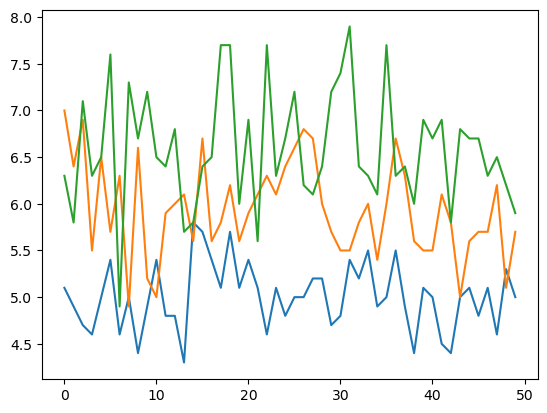

In [5]:
plt.plot(data_0[:,0])
plt.plot(data_1[:,0])
plt.plot(data_2[:,0])
plt.show()

В `matplotlib` есть понятие `subplots`. Давайте создадим 3 `subplots` для наших классов

 Если мы посмотрим на `ax.shape` - мы обнаружим что это просто массив, который содержит в себе графические объекты. Соответственно к каждому из этих `subplots` мы можем обращаться по индексу

**Для каждого класса постройте зависимость ширины от длины чашелистиков**. Используйте `ax.scatter()`

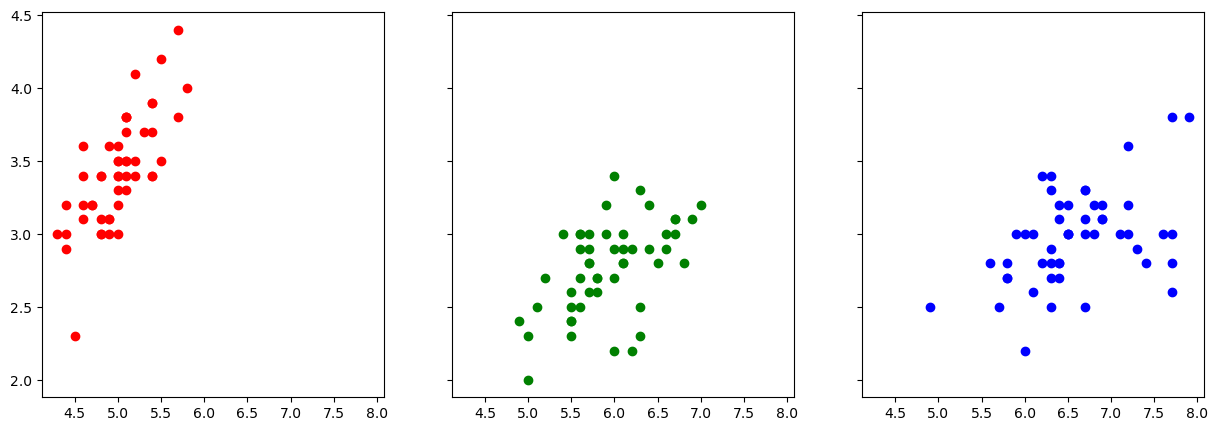

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
length0 , width0 = np.array([data_0[i][0] for i in range(len(data_0))]),np.array([data_0[i][1] for i in range(len(data_0))])
length1 , width1 = np.array([data_1[i][0] for i in range(len(data_1))]),np.array([data_1[i][1] for i in range(len(data_1))])
length2 , width2 = np.array([data_2[i][0] for i in range(len(data_2))]),np.array([data_2[i][1] for i in range(len(data_2))])
ax[0].scatter(length0 , width0, color = 'red') # Your code here 
ax[1].scatter(length1 , width1, color = 'green') # Your code here 
ax[2].scatter(length2 , width2, color = 'blue') # Your code here 
plt.show()

Визуализируйте данные из iris dataset при помощи UMAP.

Каждый объект в датасете Iris содержит 4 признака и  него можно было посмотреть как на точку в 4-мерном пространстве, если бы мы могли такое пространство визуализировать непосредственно. В одной из будущих лекций мы подробно познакомимся с различными методами понижения размерности пространства признаков, а пока посмотрим как один таких методов — [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) — можно использовать для получения двумерной аппроксимации пространства признаков датасета Iris:

In [11]:
! pip install umap-learn[plot]
from IPython.display import clear_output
clear_output()

In [12]:
import umap
import umap.plot
import pandas as pd

Рассмотрим двумерную проекцию данных при помощи UMAP:

In [13]:
mapper = umap.UMAP().fit(data)

annotation_on_plot = pd.DataFrame({'index':np.arange(len(data)),
                                   'label':labels,
                                   'sepal length in cm':data[:, 0],
                                   'sepal width in cm':data[:, 1],
                                   'petal length in cm':data[:, 2],
                                   'petal width in cm':data[:, 3]
                                   })

annotation_on_plot['item'] = annotation_on_plot.label.map(
    {
        0:'Setosa',
        1:'Versicolor',
        2:'Virginica'
    }
)

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=labels, point_size=10, 
                          hover_data=annotation_on_plot, theme='red')
umap.plot.show(p)

Loading BokehJS ...

## Использование понижения размерности для ускорения обучения

Рассмотрите набор данных TissueMNIST. В этом задании вам нужно сравнить производительность двух моделей: обученной с использованием всех доступных признаков и обученной на данных пониженной размерности. От вас требуется:

1. Посторить модель `RandomForestClassifier()` и обучить ее на тренировочной выборке, оценить `accuracy` модели на тестовой выборке и время, потраченное на обучение;
2. Построить модель PCA на тернировочных данных и определите число главных компонент, объясняющих 90% дисперсии (или используйте любой другой способ выбора оптимального числа главных компонент, разбиравшийся на лекции);
3. Спроецировать данные тестовой выборки на главные компоненты, полученной модели PCA;
4. Построить модель `RandomForestClassifier()` и обучить ее на данных пониженной размерности, оценить `accuracy` модели на тестовой выборке и время, потраченное на обучение;
5. Опишите ваши наблюдения, сделайте выводы.

_Note: Обратите внимание, что параметр `n_components` при создании экземпляра класса `PCA` может принимать не только целочисленные значения (непосредственно количество компонент в "штуках"), но и вещественные на интервале $(0, 1)$. Ознакомьтесь с описанием класса [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и определите как можно использовать вещественное `n_components` для решения задачи._

In [86]:
from tqdm.notebook import tqdm
data_flag = 'tissuemnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
tissuemnist = DataClass(split='test', download=download)
print(tissuemnist)

  0%|          | 0/124962739 [00:00<?, ?it/s]

Dataset TissueMNIST (tissuemnist)
    Number of datapoints: 47280
    Root location: /root/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'Collecting Duct, Connecting Tubule', '1': 'Distal Convoluted Tubule', '2': 'Glomerular endothelial cells', '3': 'Interstitial endothelial cells', '4': 'Leukocytes', '5': 'Podocytes', '6': 'Proximal Tubule Segments', '7': 'Thick Ascending Limb'}
    Number of samples: {'train': 165466, 'val': 23640, 'test': 47280}
    Description: We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale images.
    License: CC BY 4

In [87]:
x = tissuemnist.imgs / 255. # normalization data
x = x.reshape(-1, 784)
y = tissuemnist.labels
 
tissuemnist.montage(length=5)

x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.2)

In [88]:
%%time
from sklearn.metrics import accuracy_score
rng = np.random.RandomState(42)
rf = RandomForestClassifier(n_estimators=200, random_state=rng)
rf.fit(x_train,y_train)
predict = rf.predict(x_test)
acc = accuracy_score(y_test,predict)
print('acc of default rf', acc)

acc of default rf 0.5221023688663282
CPU times: user 3min 14s, sys: 782 ms, total: 3min 14s
Wall time: 3min 14s


In [95]:
%%time
pca_0_9 = PCA(n_components = 0.9) 
#projecting data to reduced dimension
pca_0_9.fit(x_train)
X_PCA_train = pca_0_9.transform((x_train))
X_PCA_test = pca_0_9.transform((x_test))
n_compp_0_9 = len(X_PCA_train.T)
print('optimal number of dim to save more than 90% of dispersion',n_compp_0_9)

optimal number of dim to save more than 90% of dispersion 58
CPU times: user 15.1 s, sys: 2.42 s, total: 17.5 s
Wall time: 15.3 s


In [98]:
%%time
rf_PCA = RandomForestClassifier(n_estimators=200, random_state=rng)
rf_PCA.fit(X_PCA_train,y_train)
predict = rf_PCA.predict(X_PCA_test)
acc_PCA = accuracy_score(y_test,predict)
print('acc of default rf', acc_PCA)

acc of default rf 0.503489847715736
CPU times: user 1min 27s, sys: 543 ms, total: 1min 27s
Wall time: 1min 27s


_Вывод:_

кол-во компонент,необходимых для сохраения 90% дисперсии данных оказался равен 58, что более, чем в 13 раз меньше, чем исходная размерность (784).
При этом время обучения rf на данных пониженной размерности стало вдвое меньше (3 мин 14 с vs 1 мин 27 с), а качество предсказания accuracy уменьшилось менее, чем на 0.02 (0.5034 vs 0.522), что довольно незначительно, учитывая прирост по времени более, чем в 2 раза. 
